Designed to process Iolite trace-element output.

By Khalil Droubi, UW-Madison Geoscience Dept.

In [1]:
### Makes Jupyter Notebook full width ###

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#KD default imports. Probably don't need all of these.

import pandas as pd
import os
import re
import copy
import numpy as np
import math
from scipy import stats
from scipy import optimize
from scipy.stats import linregress
import webbrowser
from random import randint


#Graphing stuff
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import plotly.express as px

%matplotlib inline

#%pip install PyPDF2
from PyPDF2 import PdfFileMerger, PdfFileReader

#%pip install pdfkit
import pdfkit

#%pip install xlsxwriter
import xlsxwriter

#pd.set_option("display.precision", 8)

In [3]:
# Functions

CI_values = {'Sr': 7.26, 'Y': 1.57, 'Zr': 3.87, 'Nb': 0.24,     #CI Values [ppm] from Sun & McDonough 1995 (?)
    'La': 0.236,'Ce': 0.612,'Pr': 0.095,'Nd': 0.467,'Sm': 0.153,
    'Eu': 0.058,'Gd': 0.2055,'Dy': 0.254,'Ho': 0.0566,'Er': 0.1655,
    'Yb': 0.17,'Lu': 0.0254,'Ta': 0.014,'Pb': 2.47,'Th': 0.029,'U': 0.008}

def read_qqq_input(filename):
    '''Excel input file is from Iolite export{Excel and Stats options}. This function will read the raw file and output just the rows that are actual ablations.'''
    
    data = pd.read_excel(filename, sheet_name = 'Data')
    data = data.rename(columns={"Unnamed: 0": "Sample ID"})

    data.dropna(subset = ["Sample ID"], inplace=True)

    indices = data['Sample ID'].values.tolist()
    key_list = []
    for name in indices:
        if '.' in name:
            key_list.append(name)
        
        
    data = data[data["Sample ID"].isin(key_list)]  
    data = data.set_index('Sample ID')
            
    return data


def just_ppm(data):
    '''Reduces columns to just to ppm averages from Iolite and then calculates the CI normalized value.'''
    
    keys = data.keys()

    col_list = []
    for col in keys:
        if 'Ca'  not in col:
            if 'ppm_mean' in col:
                col_list.append(col)

    data2 = data[col_list]
    
    data3 = data2.copy()

    data3['Sr_CInorm'] = data3.apply(lambda x: (x['Sr88_ppm_mean'] / CI_values['Sr']), axis=1)
    data3['Y_CInorm'] = data3.apply(lambda x: (x['Y89_ppm_mean'] / CI_values['Y']), axis=1)
    data3['Zr_CInorm'] = data3.apply(lambda x: (x['Zr90_ppm_mean'] / CI_values['Zr']), axis=1)
    data3['Nb_CInorm'] = data3.apply(lambda x: (x['Nb93_ppm_mean'] / CI_values['Nb']), axis=1)
    data3['La_CInorm'] = data3.apply(lambda x: (x['La139_ppm_mean'] / CI_values['La']), axis=1)
    data3['Ce_CInorm'] = data3.apply(lambda x: (x['Ce140_ppm_mean'] / CI_values['Ce']), axis=1)
    data3['Pr_CInorm'] = data3.apply(lambda x: (x['Pr141_ppm_mean'] / CI_values['Pr']), axis=1)
    data3['Nd_CInorm'] = data3.apply(lambda x: (x['Nd146_ppm_mean'] / CI_values['Nd']), axis=1)
    data3['Sm_CInorm'] = data3.apply(lambda x: (x['Sm147_ppm_mean'] / CI_values['Sm']), axis=1)
    data3['Eu_CInorm'] = data3.apply(lambda x: (x['Eu153_ppm_mean'] / CI_values['Eu']), axis=1)
    data3['Gd_CInorm'] = data3.apply(lambda x: (x['Gd157_ppm_mean'] / CI_values['Gd']), axis=1)
    data3['Dy_CInorm'] = data3.apply(lambda x: (x['Dy163_ppm_mean'] / CI_values['Dy']), axis=1)
    data3['Ho_CInorm'] = data3.apply(lambda x: (x['Ho165_ppm_mean'] / CI_values['Ho']), axis=1)
    data3['Er_CInorm'] = data3.apply(lambda x: (x['Er166_ppm_mean'] / CI_values['Er']), axis=1)
    data3['Yb_CInorm'] = data3.apply(lambda x: (x['Yb172_ppm_mean'] / CI_values['Yb']), axis=1)
    data3['Lu_CInorm'] = data3.apply(lambda x: (x['Lu175_ppm_mean'] / CI_values['Lu']), axis=1)
    data3['Ta_CInorm'] = data3.apply(lambda x: (x['Ta181_ppm_mean'] / CI_values['Ta']), axis=1)
    data3['Pb_CInorm'] = data3.apply(lambda x: (x['Pb208_ppm_mean'] / CI_values['Pb']), axis=1)
    data3['Th_CInorm'] = data3.apply(lambda x: (x['Th232_ppm_mean'] / CI_values['Th']), axis=1)
    data3['U_CInorm'] = data3.apply(lambda x: (x['U238_ppm_mean'] / CI_values['U']), axis=1)

    
    return data3
    
def order_spider_and_REE(data):
    '''Make dataframes with data in the correct order for REE and Spider plots.'''
    spider_order1 = ['Th_CInorm', 'U_CInorm','Nb_CInorm', 'Ta_CInorm', 'La_CInorm','Ce_CInorm',
                 'Pb_CInorm', 'Pr_CInorm', 'Sr_CInorm','Nd_CInorm', 'Zr_CInorm', 'Sm_CInorm', 
                 'Eu_CInorm','Gd_CInorm', 'Dy_CInorm', 'Y_CInorm', 'Ho_CInorm', 'Er_CInorm', 'Yb_CInorm','Lu_CInorm']

    REE_order1 = ['La_CInorm','Ce_CInorm', 'Pr_CInorm', 'Nd_CInorm', 'Sm_CInorm', 'Eu_CInorm',
                 'Gd_CInorm', 'Dy_CInorm', 'Ho_CInorm', 'Er_CInorm', 'Yb_CInorm','Lu_CInorm']
    
    
    spider = data[spider_order1]
    REE = data[REE_order1]
    
    return spider, REE
    
    
def export_qqq(data, filename, date):
    '''Export for processed data for plotting.'''
    
    data2 = just_ppm(data)
        
    data2_sp, dataREE = order_spider_and_REE(data2)    
    

    excel_name = 'QQQ' + date +'_processed.xlsx'
    with pd.ExcelWriter(excel_name, engine = 'xlsxwriter') as writer:
          # Get the xlsxwriter workbook objects.
        workbook  = writer.book
        
        data.to_excel(writer, sheet_name = 'raw', index = True)
        data2.to_excel(writer, sheet_name = 'ppmData', index = True)
        dataREE.to_excel(writer, sheet_name = 'REE', index = True)
        data2_sp.to_excel(writer, sheet_name = 'Spider', index = True)
         
        worksheet = writer.sheets['raw']  # pull worksheet object

        worksheet.set_column(0, 0, 18)
        worksheet.freeze_panes(1,1)
        
        
        worksheet = writer.sheets['ppmData']  # pull worksheet object

        for idx in range(21):
            worksheet.set_column(idx, idx, 14)
        worksheet.freeze_panes(1,1)
        
        worksheet = writer.sheets['REE']  # pull worksheet object
        for idx in range(14):
            worksheet.set_column(idx, idx, 16)
        worksheet.freeze_panes(1,1)
        
        worksheet = writer.sheets['Spider']  # pull worksheet object
        for idx in range(22):
            worksheet.set_column(idx, idx, 16)
        worksheet.freeze_panes(1,1)
               
def group_samples(data):

    samples = data.index.values.tolist()
    group = None
    group_names = []
    start = [0]
    end = []
    for idx in range(len(samples)):
        if group == None:
            group = samples[idx].split(' 1')[0]     #Hard-coding
            group_names.append(group)
        #print(samples[idx])
        if group in samples[idx]:
            pass
        else:
            end.append(idx)

            start.append(idx)
            name = samples[idx].split(' 1')[0]      #Hard-coding
            group = name
            group_names.append(name)
    end.append(len(samples))

#     print('start:', start)
#     print('end:', end)
#     print('group names:', group_names)
    
    start_index = start
    end_index = end
    
    return start_index, end_index, group_names

def find_log_lim(ymin, ymax):
    """ Input the minimum and maximum, and this outputs Khalil's ideal y-axis limits for trace-element Harker diagrams."""
    for idx in range(8): 
        if ymax < 1 * (10**idx):
            new_max = 1 * (10**idx)
            break
    for idx in range(8):
        #print(idx)
        if ymin > 1 * (10**idx):
            new_min = 1 * (10**(idx))
            #print(new_min)
        elif ymin < 1:
            new_min = 0.1
            break
        else:
            break
    return new_min, new_max

def comb_groups(group_list, data):
    """ Function to combine a list of group names from dataset and output a list of rows to plot as well as the number of labels that will be necessary."""
    start, end, names = group_samples(data)
    #test_group = ['Bancroft', 'BLR-1']

    #len(test_group)
    indx_list = []
    for val in group_list:
        #print(val)
        indx_list.append(names.index(val))
    #print(indx_list)
    y_list = []
    for ind in indx_list:
        for i in range(end[ind]-start[ind]):
            y1 = data.iloc[start[ind] + i]
            y_list.append(y1)


    df3 = pd.DataFrame(y_list)

    labels = len(df3.index.tolist())

    return y_list, labels, df3


In [4]:
def harker_plot(data, choice, groupID, color_choice = 'Groups', gradient_choice = '206/238 Age [Ma]'):   
    '''Makes Harker variation plots with specific REE or Spider diagram style.'''
    age_choice = gradient_choice
    group_list = []
    if type(groupID) == str:
        group_list.append(groupID)
    else:
        group_list = groupID


    #start, end, names = group_samples(data2)
    #indx = names.index(groupID)
    data2_sp, dataREE = order_spider_and_REE(data)

    if choice.upper() == 'REE':
        plot_data = dataREE
    else:
        plot_data = data2_sp

    REE_label = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Dy','Ho','Er', 'Yb', 'Lu']
    spider_label = ['Th', 'U','Nb', 'Ta', 'La','Ce','Pb', 'Pr', 'Sr','Nd', 'Zr', 'Sm', 'Eu','Gd', 'Dy', 'Y', 'Ho', 'Er', 'Yb','Lu']



    #PLOTTING
    fig, ax1 = plt.subplots(1,1, figsize = (12, 6))

    #plt.xlabel("CI normalized (log-scale)")  # add X-axis label
    plt.ylabel("CI normalized (log-scale)")  # add Y-axis label

    title = str(groupID)
    plt.title("REE plot: " + title)  # add title

    fake1, fake2, df3 = comb_groups(group_list, data)
    y_list, labels, fake_df3 = comb_groups(group_list, plot_data)
    
    color = []
    n = len(group_list)
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    
    if color_choice.upper() == 'GROUPS':
        
        for val in y_list:
            #print(val.name)
            for idx in range(len(group_list)):
                if group_list[idx] in val.name:
                    ax1.plot(val, label = val.name, color = color[idx])
        
    if color_choice.upper() == 'ALL':
        
        for val in y_list:
           
            ax1.plot(val, label = val.name)
    
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        
        age_range = df3[age_choice].values.tolist()
        age_range2 = [i for i in age_range if i != 0]
        min_val, max_val = min(age_range2), max(age_range2)
        # use the coolwarm colormap that is built-in, and goes from blue to red
        cmap = mpl.cm.coolwarm
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
        # convert your distances to color coordinates
        color_list = cmap(norm(age_range))

        
        for val in y_list:
            color1 = color_list[age_range.index(data.loc[val.name][age_choice])]
            ax1.plot(val, label = val.name, color = color1)
            
            
        #fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = ax1, orientation='vertical', label='Some Units')
        #mpl.pyplot.colorbar()
    
    n_col = 6

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol= n_col)

    #Setting y-axis scale
    ax1.set_yscale('log')
    ymin, ymax = ax1.get_ylim()    
    new_min, new_max = find_log_lim(ymin, ymax)
    ax1.set_ylim([new_min, new_max])

    # Decides whether x-axis is REE or Spider

    x_spid = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    x_ree = [0,1,2,3, 4,5,6,7,8, 9,10, 11]
    if choice.upper() == 'REE':
        ax1.set_xticks(x_ree)
        ax1.set_xticklabels(REE_label, minor=False, rotation=45)
    else:
        ax1.set_xticks(x_spid)
        ax1.set_xticklabels(spider_label, minor=False, rotation=45)

    ###
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        position=fig.add_axes([0.93,0.25,0.02,0.55])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = position, orientation='vertical', label= age_choice)
        cb.set_label(age_choice,labelpad= 15, y=0.5)



In [49]:
def just_ppm2(data):
    '''Reduces columns to just to ppm averages from Iolite and then calculates the CI normalized value. Assumes that NP2 Pb ppm has been calculated.'''
    
    keys = data.keys()

    col_list = []
    for col in keys:
        if 'Ca'  not in col:
            if 'ppm_mean' in col:
                col_list.append(col)
            elif 'Total NP2 Pb ppm' in col:
                col_list.append(col)
            elif '207/206 Age [Ma]' in col:
                col_list.append(col)

    data2 = data[col_list]
    
    data3 = data2.copy()

    data3['Sr_CInorm'] = data3.apply(lambda x: (x['Sr88_ppm_mean'] / CI_values['Sr']), axis=1)
    data3['Y_CInorm'] = data3.apply(lambda x: (x['Y89_ppm_mean'] / CI_values['Y']), axis=1)
    data3['Zr_CInorm'] = data3.apply(lambda x: (x['Zr90_ppm_mean'] / CI_values['Zr']), axis=1)
    data3['Nb_CInorm'] = data3.apply(lambda x: (x['Nb93_ppm_mean'] / CI_values['Nb']), axis=1)
    data3['La_CInorm'] = data3.apply(lambda x: (x['La139_ppm_mean'] / CI_values['La']), axis=1)
    data3['Ce_CInorm'] = data3.apply(lambda x: (x['Ce140_ppm_mean'] / CI_values['Ce']), axis=1)
    data3['Pr_CInorm'] = data3.apply(lambda x: (x['Pr141_ppm_mean'] / CI_values['Pr']), axis=1)
    data3['Nd_CInorm'] = data3.apply(lambda x: (x['Nd146_ppm_mean'] / CI_values['Nd']), axis=1)
    data3['Sm_CInorm'] = data3.apply(lambda x: (x['Sm147_ppm_mean'] / CI_values['Sm']), axis=1)
    data3['Eu_CInorm'] = data3.apply(lambda x: (x['Eu153_ppm_mean'] / CI_values['Eu']), axis=1)
    data3['Gd_CInorm'] = data3.apply(lambda x: (x['Gd157_ppm_mean'] / CI_values['Gd']), axis=1)
    data3['Dy_CInorm'] = data3.apply(lambda x: (x['Dy163_ppm_mean'] / CI_values['Dy']), axis=1)
    data3['Ho_CInorm'] = data3.apply(lambda x: (x['Ho165_ppm_mean'] / CI_values['Ho']), axis=1)
    data3['Er_CInorm'] = data3.apply(lambda x: (x['Er166_ppm_mean'] / CI_values['Er']), axis=1)
    data3['Yb_CInorm'] = data3.apply(lambda x: (x['Yb172_ppm_mean'] / CI_values['Yb']), axis=1)
    data3['Lu_CInorm'] = data3.apply(lambda x: (x['Lu175_ppm_mean'] / CI_values['Lu']), axis=1)
    data3['Ta_CInorm'] = data3.apply(lambda x: (x['Ta181_ppm_mean'] / CI_values['Ta']), axis=1)
    data3['Pb_CInorm'] = data3.apply(lambda x: (x['Total NP2 Pb ppm'] / CI_values['Pb']), axis=1)
    data3['Th_CInorm'] = data3.apply(lambda x: (x['Th232_ppm_mean'] / CI_values['Th']), axis=1)
    data3['U_CInorm'] = data3.apply(lambda x: (x['U238_ppm_mean'] / CI_values['U']), axis=1)
    
    #Ratio calcs
    
    data3['Th/U'] = data3.apply(lambda x: (x['Th232_ppm_mean'] / x['U238_ppm_mean']), axis=1)
    data3['Th/Pb'] = data3.apply(lambda x: (x['Th232_ppm_mean'] / x['Total NP2 Pb ppm']), axis=1)
    data3['U/Pb'] = data3.apply(lambda x: (x['U238_ppm_mean'] / x['Total NP2 Pb ppm']), axis=1)
    
    
    data3['(La/Yb)n'] = data3.apply(lambda x: (x['La_CInorm'] / x['Yb_CInorm']), axis=1)
    data3['(La/Sm)n'] = data3.apply(lambda x: (x['La_CInorm'] / x['Sm_CInorm']), axis=1)
    data3['(Dy/Yb)n'] = data3.apply(lambda x: (x['Dy_CInorm'] / x['Yb_CInorm']), axis=1)
    data3['(Nb/Ta)n'] = data3.apply(lambda x: (x['Nb_CInorm'] / x['Ta_CInorm']), axis=1)
    data3['(Eu/Eu*)n'] = data3.apply(lambda x: (x['Eu_CInorm'] / math.sqrt(x['Sm_CInorm'] * x['Gd_CInorm'])), axis=1)
    data3['sumLREE'] = data3.apply(lambda x: (x['La139_ppm_mean'] +x['Ce140_ppm_mean']+ x['Pr141_ppm_mean'] + x['Nd146_ppm_mean'] + x['Sm147_ppm_mean']), axis=1)                                 
    data3['10*Y'] = data3.apply(lambda x: (x['Y89_ppm_mean'] *10), axis=1)
    data3['100*Sr'] = data3.apply(lambda x: (x['Sr88_ppm_mean'] *100), axis=1)
    data3['1000*Th/U'] = data3.apply(lambda x: (x['Th/U'] *1000), axis=1)
    data3['100*U'] = data3.apply(lambda x: (x['U238_ppm_mean'] *100), axis=1)
    data3['100*Pb'] = data3.apply(lambda x: (x['Total NP2 Pb ppm'] *100), axis=1)
    
    
    
    data3['Sample'] = data3.apply(lambda x: (x.name.split('_')[0]), axis=1)
    
    new_df = data3.replace('SAB-95-65c','95-65')
    data3 = new_df.replace('SAB-95-65b','95-65')
    data3 = data3.replace('SB-91-53','91-53')
    data3 = data3.replace('SAB-94-134','94-134')
    
    
    
    return data3

def group_samples2(data):

    samples = data.index.values.tolist()
    group = None
    samp = None
    group_names = []
    start = [0]
    end = []
    for idx in range(len(samples)):
        #print(samp)
        if samp == None:
            group = samples[idx].split(' 1')[0] #Hard-coding
            samp = group.split('_')[0]
            group_names.append(samp)
        #print(samples[idx])
        if samp in samples[idx]:
            pass
        else:
            end.append(idx)

            start.append(idx)
            name = samples[idx].split(' 1')[0] #Hard-coding
            group = name
            name1 = name.split('_')[0]
            samp = name1
            group_names.append(name1)
    end.append(len(samples))

#     print('start:', start)
#     print('end:', end)
#     print('group names:', group_names)
    
    start_index = start
    end_index = end
    
    return start_index, end_index, group_names

def comb_groups2(group_list, data):
    """ Function to combine a list of group names from dataset and output a list of rows to plot as well as the number of labels that will be necessary."""
    start, end, names = group_samples2(data)
    #test_group = ['Bancroft', 'BLR-1']

    #len(test_group)
    indx_list = []
    for val in group_list:
        if val not in names:
            continue
        #print(val)
        else:
            indx_list.append(names.index(val))
    #print(indx_list)
    y_list = []
    for ind in indx_list:
        for i in range(end[ind]-start[ind]):
            y1 = data.iloc[start[ind] + i]
            y_list.append(y1)


    df3 = pd.DataFrame(y_list)

    labels = len(df3.index.tolist())

    return y_list, labels, df3

def harker_plot2(data, choice, groupID, color_choice = 'Groups', gradient_choice = '207/206 Age [Ma]', cut_choice = 'False',cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True):   
    '''Makes Harker variation plots with specific REE or Spider diagram style. Color_choice options: all, age/gradient, groups'''
    age_choice = gradient_choice
    group_list = []
    if type(groupID) == str:
        group_list.append(groupID)
    else:
        group_list = groupID
    #print('original: ',group_list)
        
    #data_orig = data

    #start, end, names = group_samples(data2)
    #indx = names.index(groupID)
    #print(data[cut)
    if cut_choice:
        if cut_dir.upper() == 'TOP':
            data = data[data[cut_col] < cut_off ]
        else:
            data = data[data[cut_col] > cut_off ]
        #print(data.index.to_list())
        start, end, group_list = group_samples2(data1)
    #print('new: ',group_list)
                
    data2_sp, dataREE = order_spider_and_REE(data)

    if choice.upper() == 'REE':
        plot_data = dataREE
    else:
        plot_data = data2_sp

    REE_label = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Dy','Ho','Er', 'Yb', 'Lu']
    spider_label = ['Th', 'U','Nb', 'Ta', 'La','Ce','Pb', 'Pr', 'Sr','Nd', 'Zr', 'Sm', 'Eu','Gd', 'Dy', 'Y', 'Ho', 'Er', 'Yb','Lu']



    #PLOTTING
    fig, ax1 = plt.subplots(1,1, figsize = (12, 6))

    #plt.xlabel("CI normalized (log-scale)")  # add X-axis label
    plt.ylabel("CI normalized (log-scale)")  # add Y-axis label

    title = str(groupID)
    if cut_choice:
        if cut_dir.upper() == 'TOP':
            title = title + '; ' + cut_col + '< ' + str(cut_off)
            plt.title(title)
        else:
            title = title + '; ' + cut_col+ '> '+ str(cut_off)
            plt.title(title)    
    else:
        plt.title(title)  # add title
    

    fake1, fake2, df3 = comb_groups2(group_list, data)
    y_list, labels, fake_df3 = comb_groups2(group_list, plot_data)
    
    color = []
    n = len(group_list)
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    if n <= 9:
        color = [ 'royalblue','orangered','black','darkgoldenrod','mediumorchid','blue', 'green', 'red', 'yellow']
    
    legend_list = [None]
    if color_choice.upper() == 'GROUPS':
        
        for val in y_list:
            #print(val.name)
            for idx in range(len(group_list)):
                if legend_list[-1] == None:
                    ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                    legend_list.append(val.name.split('_')[0])
                
                    
                elif group_list[idx] in val.name:
                    if legend_list[-1] == val.name.split('_')[0]:
                        ax1.plot(val, label = '_nolegend_', color = color[idx])
                    else:
                        ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                        legend_list.append(val.name.split('_')[0])
        
    if color_choice.upper() == 'ALL':
        
        for val in y_list:
           
            ax1.plot(val, label = val.name)
    
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        
        age_range = df3[age_choice].values.tolist()
        age_range2 = [i for i in age_range if i != 0]
        min_val, max_val = min(age_range2), max(age_range2)
        
        # use the coolwarm colormap that is built-in, and goes from blue to red
        cmap = mpl.cm.get_cmap('seismic', 6)
        #cmap = mpl.cm.seismic
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
        # convert your distances to color coordinates
        color_list = cmap(norm(age_range))

        
        for val in y_list:
            color1 = color_list[age_range.index(data.loc[val.name][age_choice])]
            ax1.plot(val, label = val.name, color = color1)
            
    
    n_col = 6

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    if legend:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol= n_col)

    #Setting y-axis scale
    ax1.set_yscale('log')
    ymin, ymax = ax1.get_ylim()    
    new_min, new_max = find_log_lim(ymin, ymax)
    ax1.set_ylim([new_min, new_max])

    # Decides whether x-axis is REE or Spider

    x_spid = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    x_ree = [0,1,2,3, 4,5,6,7,8, 9,10, 11]
    if choice.upper() == 'REE':
        ax1.set_xticks(x_ree)
        ax1.set_xticklabels(REE_label, minor=False, rotation=45)
    else:
        ax1.set_xticks(x_spid)
        ax1.set_xticklabels(spider_label, minor=False, rotation=45)

    ###
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        position=fig.add_axes([0.93,0.25,0.02,0.55])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = position, orientation='vertical', label= age_choice)
        cb.set_label(age_choice,labelpad= 15, y=0.5)


def harker_plot3(data, choice, groupID, color_choice = 'Groups', gradient_choice = '207/206 Age [Ma]', cut_choice = False,cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True):   
    '''Makes Harker variation plots with specific REE or Spider diagram style. Color_choice options: all, age/gradient, groups'''
    age_choice = gradient_choice
    group_list = []
    if type(groupID) == str:
        group_list.append(groupID)
    else:
        group_list = groupID
    #print('original: ',group_list)
        
    #data_orig = data

    #start, end, names = group_samples(data2)
    #indx = names.index(groupID)
    #print(data[cut)
    if cut_choice:
        if cut_dir.upper() == 'top':
            data = data[data[cut_col] < cut_off ]
        else:
            data = data[data[cut_col] > cut_off ]
        #print(data.index.to_list())
        start, end, group_list = group_samples(data1)
    #print('new: ',group_list)
                
    data2_sp, dataREE = order_spider_and_REE(data)

    if choice.upper() == 'REE':
        plot_data = dataREE
    else:
        plot_data = data2_sp

    REE_label = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Dy','Ho','Er', 'Yb', 'Lu']
    spider_label = ['Th', 'U','Nb', 'Ta', 'La','Ce','Pb', 'Pr', 'Sr','Nd', 'Zr', 'Sm', 'Eu','Gd', 'Dy', 'Y', 'Ho', 'Er', 'Yb','Lu']



    #PLOTTING
    fig, ax1 = plt.subplots(1,1, figsize = (12, 6))

    #plt.xlabel("CI normalized (log-scale)")  # add X-axis label
    plt.ylabel("CI normalized (log-scale)")  # add Y-axis label

    title = str(groupID)
    if cut_choice:
        if cut_dir.upper() == 'top':
            title = title + '; ' + cut_col + '< ' + str(cut_off)
            plt.title(title)
        else:
            title = title + '; ' + cut_col+ '> '+ str(cut_off)
            plt.title(title)    
    else:
        plt.title(title)  # add title
    

    fake1, fake2, df3 = comb_groups(group_list, data)
    y_list, labels, fake_df3 = comb_groups(group_list, plot_data)
    
    color = []
    n = len(group_list)
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    if n <= 9:
        color = [ 'royalblue','orangered','black','darkgoldenrod','mediumorchid','blue', 'green', 'red', 'yellow']
    
    legend_list = [None]
    if color_choice.upper() == 'GROUPS':
        
        for val in y_list:
            #print(val.name)
            for idx in range(len(group_list)):
                if legend_list[-1] == None:
                    ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                    legend_list.append(val.name.split('_')[0])
                
                    
                elif group_list[idx] in val.name:
                    if legend_list[-1] == val.name.split('_')[0]:
                        ax1.plot(val, label = '_nolegend_', color = color[idx])
                    else:
                        ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                        legend_list.append(val.name.split('_')[0])
        
    if color_choice.upper() == 'ALL':
        
        for val in y_list:
           
            ax1.plot(val, label = val.name)
    
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        
        age_range = df3[age_choice].values.tolist()
        age_range2 = [i for i in age_range if i != 0]
        min_val, max_val = min(age_range2), max(age_range2)
        
        # use the coolwarm colormap that is built-in, and goes from blue to red
        cmap = mpl.cm.get_cmap('seismic', 6)
        #cmap = mpl.cm.seismic
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
        # convert your distances to color coordinates
        color_list = cmap(norm(age_range))

        
        for val in y_list:
            color1 = color_list[age_range.index(data.loc[val.name][age_choice])]
            ax1.plot(val, label = val.name, color = color1)
            
    
    n_col = 6

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    if legend:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol= n_col)

    #Setting y-axis scale
    ax1.set_yscale('log')
    ymin, ymax = ax1.get_ylim()    
    new_min, new_max = find_log_lim(ymin, ymax)
    ax1.set_ylim([new_min, new_max])

    # Decides whether x-axis is REE or Spider

    x_spid = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    x_ree = [0,1,2,3, 4,5,6,7,8, 9,10, 11]
    if choice.upper() == 'REE':
        ax1.set_xticks(x_ree)
        ax1.set_xticklabels(REE_label, minor=False, rotation=45)
    else:
        ax1.set_xticks(x_spid)
        ax1.set_xticklabels(spider_label, minor=False, rotation=45)

    ###
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        position=fig.add_axes([0.93,0.25,0.02,0.55])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = position, orientation='vertical', label= age_choice)
        cb.set_label(age_choice,labelpad= 15, y=0.5)



def harker_plot4(data, choice, groupID, color_choice = 'Groups', gradient_choice = '207/206 Age [Ma]', cut_choice = 'False',cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True):   
    '''Makes Harker variation plots with specific REE or Spider diagram style. Color_choice options: all, age/gradient, groups'''
    age_choice = gradient_choice
    group_list = []
    if type(groupID) == str:
        group_list.append(groupID)
    else:
        group_list = groupID
    #print('original: ',group_list)
        
    #data_orig = data

    #start, end, names = group_samples(data2)
    #indx = names.index(groupID)
    #print(data[cut)
    if cut_choice:
        if cut_dir.upper() == 'top':
            data = data[data[cut_col] < cut_off ]
        else:
            data = data[data[cut_col] > cut_off ]
        #print(data.index.to_list())
        start, end, group_list = group_samples(data1)
    #print('new: ',group_list)
                
    data2_sp, dataREE = order_spider_and_REE(data)

    if choice.upper() == 'REE':
        plot_data = dataREE
    else:
        plot_data = data2_sp

    REE_label = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Dy','Ho','Er', 'Yb', 'Lu']
    spider_label = ['Th', 'U','Nb', 'Ta', 'La','Ce','Pb', 'Pr', 'Sr','Nd', 'Zr', 'Sm', 'Eu','Gd', 'Dy', 'Y', 'Ho', 'Er', 'Yb','Lu']



    #PLOTTING
    fig, ax1 = plt.subplots(1,1, figsize = (12, 6))

    #plt.xlabel("CI normalized (log-scale)")  # add X-axis label
    plt.ylabel("CI normalized (log-scale)")  # add Y-axis label

    title = str(groupID)
#     if cut_choice:
#         if cut_dir.upper() == 'top':
#             title = title + '; ' + cut_col + '< ' + str(cut_off)
#             plt.title(title)
#         else:
#             title = title + '; ' + cut_col+ '> '+ str(cut_off)
#             plt.title(title)    
#     else:
    plt.title(title)  # add title
    

    fake1, fake2, df3 = comb_groups(group_list, data)
    y_list, labels, fake_df3 = comb_groups(group_list, plot_data)
    
    color = []
    n = len(group_list)
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    if n <= 9:
        color = [ 'royalblue','orangered','black','darkgoldenrod','mediumorchid','blue', 'green', 'red', 'yellow']
    
    legend_list = [None]
    if color_choice.upper() == 'GROUPS':
        
        for val in y_list:
            #print(val.name)
            for idx in range(len(group_list)):
                if legend_list[-1] == None:
                    ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                    legend_list.append(val.name.split('_')[0])
                
                    
                elif group_list[idx] in val.name:
                    if legend_list[-1] == val.name.split('_')[0]:
                        ax1.plot(val, label = '_nolegend_', color = color[idx])
                    else:
                        ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                        legend_list.append(val.name.split('_')[0])
        
    if color_choice.upper() == 'ALL':
        
        for val in y_list:
           
            ax1.plot(val, label = val.name)
    
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        
        age_range = df3[age_choice].values.tolist()
        age_range2 = [i for i in age_range if i != 0]
        min_val, max_val = min(age_range2), max(age_range2)
        
        # use the coolwarm colormap that is built-in, and goes from blue to red
        cmap = mpl.cm.get_cmap('seismic', 8)
        #cmap = mpl.cm.seismic
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
        # convert your distances to color coordinates
        color_list = cmap(norm(age_range))

        
        for val in y_list:
            color1 = color_list[age_range.index(data.loc[val.name][age_choice])]
            ax1.plot(val, label = val.name.split('.')[-1], color = color1)
            
    
    n_col = 6

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    if legend:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol= n_col)

    #Setting y-axis scale
    ax1.set_yscale('log')
    ymin, ymax = ax1.get_ylim()    
    new_min, new_max = find_log_lim(ymin, ymax)
    ax1.set_ylim([new_min, new_max])

    # Decides whether x-axis is REE or Spider

    x_spid = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    x_ree = [0,1,2,3, 4,5,6,7,8, 9,10, 11]
    if choice.upper() == 'REE':
        ax1.set_xticks(x_ree)
        ax1.set_xticklabels(REE_label, minor=False, rotation=45)
    else:
        ax1.set_xticks(x_spid)
        ax1.set_xticklabels(spider_label, minor=False, rotation=45)

    ###
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        position=fig.add_axes([0.93,0.25,0.02,0.55])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = position, orientation='vertical', label= age_choice)
        cb.set_label(age_choice,labelpad= 15, y=0.5)

    plt.savefig("ree_test.svg")





In [ ]:
#Running code

#filename = 'QQQ_20211116_input.xlsx'
#date = '16Nov2021'

#data = read_qqq_input(filename)
#data2 = just_ppm(data)

#Exports data to .xlsx file
#export_qqq(data, filename, date)

In [50]:
filename2 = 'LASS_agu.xlsx'


data_test2 = pd.read_excel(filename2, sheet_name = 'all_unk_filt1', index_col = 0)
data_test2.keys()
data1 = just_ppm2(data_test2)
start, end, groups1 = group_samples2(data1)
#print(start)
#print(end)
print(groups1)
data_test2

['95-69', '95-65', '91-39', '94-77', 'SAB-94-134', 'SAB-95-65b', 'SAB-95-65c', 'SB-91-53']


,Total NP2 Pb ppm,206/204_after rejection,238/206,206/238 corrected Sx%,207/206 corrected,207/206 corrected Sx%,207/206 Age [Ma],Sr88_ppm_mean,Sr88_ppm_2SE(int),Y89_ppm_mean,...,Lu175_ppm_mean,Lu175_ppm_2SE(int),Ta181_ppm_mean,Ta181_ppm_2SE(int),Pb208_ppm_mean,Pb208_ppm_2SE(int),Th232_ppm_mean,Th232_ppm_2SE(int),U238_ppm_mean,U238_ppm_2SE(int)
95-69_t30 1.1,80.488818,10992.885098,1.724455,2.685609,0.220402,1.546268,2982.907664,27.895454,1.060147,3197.188381,...,35.269646,0.955762,159.727775,6.693511,66.598130,3.730356,274.352982,14.968919,57.774201,2.922470
95-69_t30 1.2,84.161854,629.732693,1.677814,2.707872,0.223604,1.522909,3006.103750,28.178344,0.991035,3741.538630,...,37.952930,1.120219,375.805199,63.658123,70.712980,4.420464,278.545516,14.620714,57.440552,3.129657
95-69_t30 1.3,77.955875,1328.326317,1.706289,2.691273,0.220006,1.517229,2980.011550,27.795939,1.222975,4265.155370,...,40.703013,1.451468,593.417702,67.836523,62.408956,3.665574,260.285672,14.573691,57.432081,2.792420
95-69_t1 1.1,152.712072,6551.583882,1.595439,2.681180,0.250403,1.506600,3186.605128,30.678291,1.156916,1091.658846,...,15.201211,0.448162,61.933828,2.697209,91.935516,6.190386,374.532772,20.720231,116.667958,6.286729
95-69_t1 1.2,167.898628,3190.469754,1.459422,2.709575,0.270140,1.505621,3306.134137,30.318217,1.139492,916.779511,...,10.555488,0.347252,97.228355,4.381900,151.266213,9.767969,559.419266,32.745682,93.436789,5.141100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SB-91-53_t15 1.1,16.748470,7573.325902,1.476792,4.196920,0.270209,1.381351,3306.530554,20.665680,0.773745,404.131138,...,6.559371,0.284101,8.206677,0.430235,1.213741,0.157634,1.791173,0.186075,21.887513,1.431009
SB-91-53_t15 1.2,10.090729,774.423091,1.463517,4.288217,0.274573,1.414205,3331.632391,19.571900,0.862060,329.135509,...,5.067783,0.298153,2.515953,0.185800,0.986179,0.153148,0.895181,0.091492,13.334046,1.091734
SB-91-53_t15 1.3,6.469026,541.507698,1.570805,4.486429,0.274086,1.556529,3328.852604,16.490491,0.653376,460.178327,...,8.074945,0.412779,2.472259,0.364048,0.896492,0.106644,0.971836,0.127932,8.568606,0.779481
SB-91-53_t16 1.1,5.430723,631.109453,1.421349,4.651383,0.325312,1.634083,3594.443901,17.573841,0.895264,639.289528,...,11.343675,0.418665,2.874766,0.305357,0.943390,0.143148,0.963219,0.111159,6.256203,0.484310


In [51]:
data_test3 = pd.read_excel(filename2, sheet_name = 'all_unk_code', index_col = 0)

data_cherry = just_ppm2(data_test3)
start, end, groups_ch = group_samples2(data_cherry)
#print(start)
#print(end)
print(groups_ch)


['95-69', '95-65', '91-39', '94-77', 'SAB-94-134', 'SAB-95-65b', 'SAB-95-65c', 'SB-91-53']


In [12]:
def harker_plot5(data, choice, groupID, color_choice = 'Groups', gradient_choice = '207/206 Age [Ma]', 
                 cut_choice = 'False',cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True, svg_name = 'fig1.svg'):   
    '''Makes Harker variation plots with specific REE or Spider diagram style. Color_choice options: all, age/gradient, groups'''
    age_choice = gradient_choice
    group_list = []
    if type(groupID) == str:
        group_list.append(groupID)
    else:
        group_list = groupID
    #print('original: ',group_list)
        
    #data_orig = data

    #start, end, names = group_samples(data2)
    #indx = names.index(groupID)
    #print(data[cut)
    if cut_choice:
        if cut_dir.upper() == 'TOP':
            data = data[data[cut_col] < cut_off ]
        else:
            data = data[data[cut_col] > cut_off ]
        #print(data.index.to_list())
        start, end, group_list = group_samples2(data1)
    #print('new: ',group_list)
                
    data2_sp, dataREE = order_spider_and_REE(data)

    if choice.upper() == 'REE':
        plot_data = dataREE
    else:
        plot_data = data2_sp

    REE_label = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Dy','Ho','Er', 'Yb', 'Lu']
    spider_label = ['Th', 'U','Nb', 'Ta', 'La','Ce','Pb', 'Pr', 'Sr','Nd', 'Zr', 'Sm', 'Eu','Gd', 'Dy', 'Y', 'Ho', 'Er', 'Yb','Lu']



    #PLOTTING
    fig, ax1 = plt.subplots(1,1, figsize = (12, 6))

    #plt.xlabel("CI normalized (log-scale)")  # add X-axis label
    #plt.ylabel("CI normalized (log-scale)")  # add Y-axis label

    title = str(groupID)
#     if cut_choice:
#         if cut_dir.upper() == 'TOP':
#             title = title + '; ' + cut_col + '< ' + str(cut_off)
#             plt.title(title)
#         else:
#             title = title + '; ' + cut_col+ '> '+ str(cut_off)
#             plt.title(title)    
#     else:
    #plt.title(title)  # add title
    

    fake1, fake2, df3 = comb_groups2(group_list, data)
    y_list, labels, fake_df3 = comb_groups2(group_list, plot_data)
    
    color = []
    n = len(group_list)
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    if n <= 9:
        color = [ 'royalblue','orangered','black','darkgoldenrod','mediumorchid','blue', 'green', 'red', 'yellow']
    
    legend_list = [None]
    if color_choice.upper() == 'GROUPS':
        
        for val in y_list:
            #print(val.name)
            for idx in range(len(group_list)):
                if legend_list[-1] == None:
                    ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                    legend_list.append(val.name.split('_')[0])
                
                    
                elif group_list[idx] in val.name:
                    if legend_list[-1] == val.name.split('_')[0]:
                        ax1.plot(val, label = '_nolegend_', color = color[idx])
                    else:
                        ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                        legend_list.append(val.name.split('_')[0])
        
    if color_choice.upper() == 'ALL':
        
        for val in y_list:
           
            ax1.plot(val, label = val.name)
    
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        
        age_range = df3[age_choice].values.tolist()
        age_range2 = [i for i in age_range if i != 0]
        min_val, max_val = min(age_range2), max(age_range2)
        
        # use the coolwarm colormap that is built-in, and goes from blue to red
        cmap = mpl.cm.get_cmap('seismic', 6
                              )
        #cmap = mpl.cm.seismic
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
        # convert your distances to color coordinates
        color_list = cmap(norm(age_range))

        
        for val in y_list:
            color1 = color_list[age_range.index(data.loc[val.name][age_choice])]
            ax1.plot(val, label = val.name, color = color1)
            
    
    n_col = 6

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
#     if legend:
#         ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
#               fancybox=True, shadow=True, ncol= n_col)

    #Setting y-axis scale
    ax1.set_yscale('log')
    ymin, ymax = ax1.get_ylim()    
    new_min, new_max = find_log_lim(ymin, ymax)
    ax1.set_ylim([new_min, new_max])

    # Decides whether x-axis is REE or Spider

    x_spid = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    x_ree = [0,1,2,3, 4,5,6,7,8, 9,10, 11]
    if choice.upper() == 'REE':
        ax1.set_xticks(x_ree)
        ax1.set_xticklabels(REE_label, minor=False, rotation=0)
    else:
        ax1.set_xticks(x_spid)
        ax1.set_xticklabels(spider_label, minor=False, rotation=45)

    ###
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        position=fig.add_axes([0.93,0.25,0.02,0.55])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = position, orientation='vertical')
        cb.ax.tick_params(labelsize=16)
        tick_locator = ticker.MaxNLocator(nbins=6)
        cb.locator = tick_locator
        cb.update_ticks()
        #cb.set_label('207Pb/206Pb Date [Ma]',labelpad= 15, y=0.5)

 
    #plt.savefig(svg_name, bbox_inches = 'tight')



In [8]:
mpl.rcParams.update({'font.size': 18, 
                     'font.family': 'sans-serif',
                     'font.weight': 'bold'
                    })

In [10]:
fig1 = ['95-69', ['95-65','SAB-95-65b', 'SAB-95-65c'], '91-39', '94-77', 'SAB-94-134',  'SB-91-53']

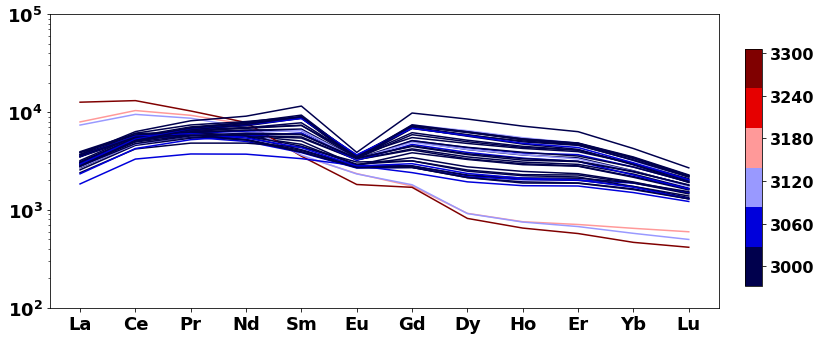

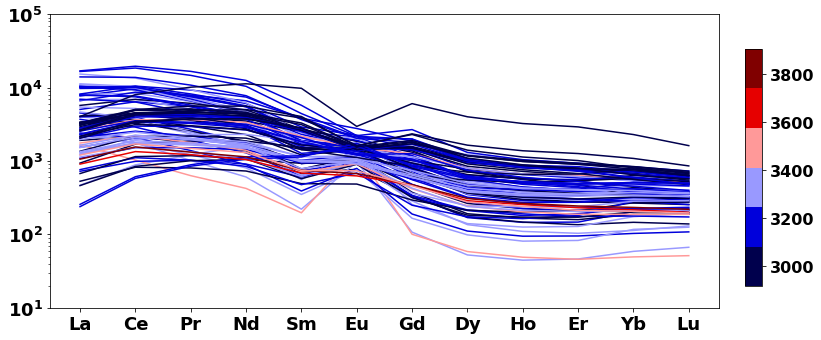

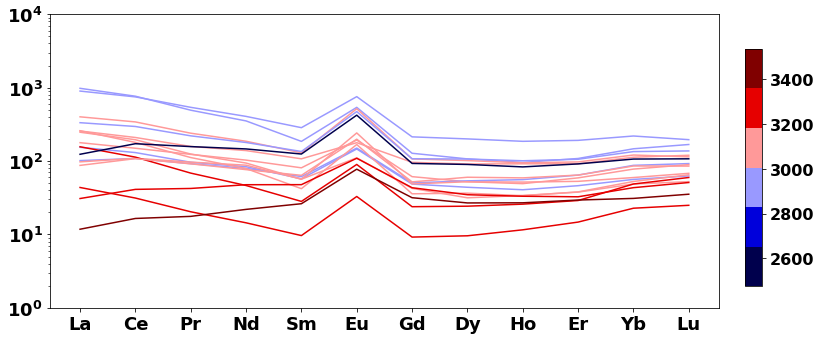

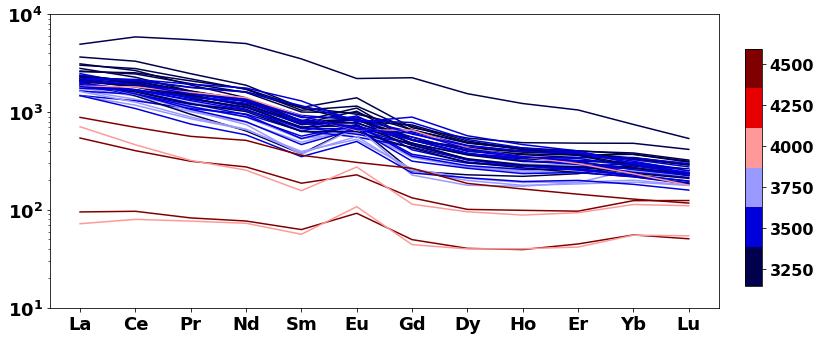

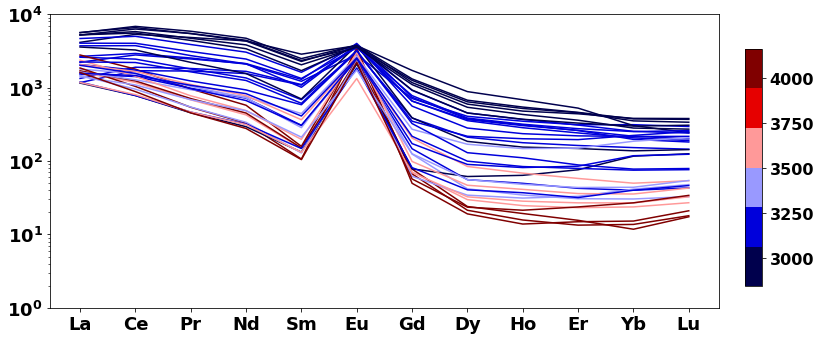

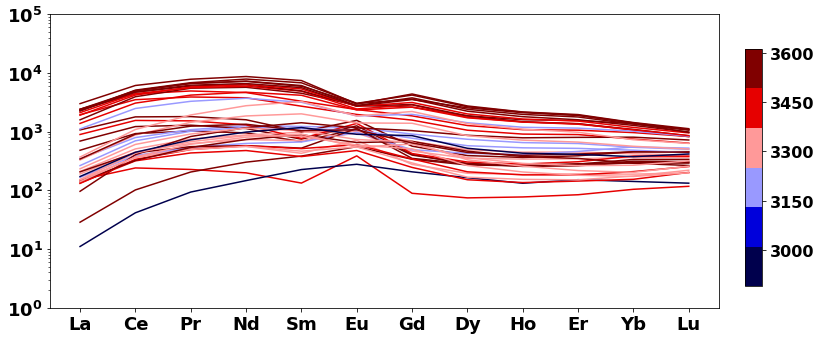

In [36]:
choice = 'ree'
for idx in range(len(fig1)):
    
    harker_plot5(data_cherry, choice, fig1[idx], color_choice = 'AGE', gradient_choice = '207/206 Age [Ma]', cut_choice = False,cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True, svg_name = 'cherry_'+ str(idx)+ '.pdf')  
   
  

In [ ]:
choice = 'ree'
for idx in range(len(fig1)):
    
    harker_plot5(data1, choice, fig1[idx], color_choice = 'AGE', gradient_choice = '207/206 Age [Ma]', cut_choice = False,cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True, svg_name = 'fig_'+ str(idx)+ '.pdf')  
   
  


In [ ]:
data_dict= {}

for idx in range(len(groups1)):
    
    data_dict[groups1[idx]] =  data1[start[idx]:end[idx]]
    


In [ ]:
def comb_samp_df(sampl_list, data = data_dict):
    df = data[sampl_list[0]]
    
    for i in range(len(sampl_list)):
        if i == 0:
            continue
        else:
            df = pd.concat([df,data[sampl_list[i]]])
            
    return df

#comb_samp_df(['95-69', '95-65',])
print(groups1)

In [14]:
def Scib_scatter(data, x= 'Y89_ppm_mean', y='Zr90_ppm_mean', color = 'Sample'):
    
    
    
    
    if x == 'sumLREE' or y == 'sumLREE':
        fig = px.scatter(data,  x,y,color, log_x = False, log_y = False, #range_y=[0,15000],
                width=800, height=800, #color_discrete_sequence=["blue", " green", "orangered", "goldenrod", "magenta", 'brown'],
                         labels={
             'U238_ppm_mean': "U ppm",
             'sumLREE': "LREE ppm",}, 
              )
    
    elif x == '207/206 Age [Ma]':
        if '/' in y:
             fig = px.scatter(data,  x,y,color, log_x = False, log_y = False, range_x=[2500,4000], 
                width=800, height=800)
        else:       
             fig = px.scatter(data1,  x,y,color, log_x = False, log_y = True, range_x=[2500,4000], range_y=[1,10000],
                width=800, height=800)   
                
    elif y == '207/206 Age [Ma]':
        if '/' in x:
            fig = px.scatter(data,  x,y,color, log_x = False, log_y = False, range_y=[2500,4000],
                width=800, height=800)
        else:
            fig = px.scatter(data1,  x,y,color, log_x = True, log_y = False, range_x=[1,10000],range_y=[2500,4000],
                width=800, height=800)
    else:
        if '/' in x and  '/' in y: 
            fig = px.scatter(data,  x,y,color, log_x = False, log_y = False, 
                width=800, height=800)
        elif '/' in x:
            fig = px.scatter(data,  x,y,color, log_x = False, log_y = True, range_y=[1,10000],
                width=800, height=800)
        elif '/' in y:
            fig = px.scatter(data,  x,y,color, log_x = True, log_y = False, range_x=[1,10000],
                width=800, height=800)
        else:
            fig = px.scatter(data,  x,y,color, log_x = True, log_y = True, range_x=[1,10000], range_y=[1,10000],
                width=800, height=800)
            
            
    
            
            
    fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
    
    fig.update_layout(
    #title="Plot Title",
    #xaxis_title="X Axis Title",
    #yaxis_title="Y Axis Title",
    legend_title="Samples",
    font=dict(
        #family="Courier New, monospace",
        size=18,
        #color="RebeccaPurple"
    )
)
    fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
    fig.update_xaxes(title_font=dict(size=34, ))
    fig.update_yaxes(title_font=dict(size=34, ))
    fig.show()
    #fig.write_image("scib1.pdf")
 


In [16]:
data_cherry.keys()

Index(['Total NP2 Pb ppm', '207/206 Age [Ma]', 'Sr88_ppm_mean', 'Y89_ppm_mean',
       'Zr90_ppm_mean', 'Nb93_ppm_mean', 'La139_ppm_mean', 'Ce140_ppm_mean',
       'Pr141_ppm_mean', 'Nd146_ppm_mean', 'Sm147_ppm_mean', 'Eu153_ppm_mean',
       'Gd157_ppm_mean', 'Dy163_ppm_mean', 'Ho165_ppm_mean', 'Er166_ppm_mean',
       'Yb172_ppm_mean', 'Lu175_ppm_mean', 'Ta181_ppm_mean', 'Pb208_ppm_mean',
       'Th232_ppm_mean', 'U238_ppm_mean', 'Sr_CInorm', 'Y_CInorm', 'Zr_CInorm',
       'Nb_CInorm', 'La_CInorm', 'Ce_CInorm', 'Pr_CInorm', 'Nd_CInorm',
       'Sm_CInorm', 'Eu_CInorm', 'Gd_CInorm', 'Dy_CInorm', 'Ho_CInorm',
       'Er_CInorm', 'Yb_CInorm', 'Lu_CInorm', 'Ta_CInorm', 'Pb_CInorm',
       'Th_CInorm', 'U_CInorm', 'Th/U', 'Th/Pb', 'U/Pb', '(La/Yb)n',
       '(La/Sm)n', '(Dy/Yb)n', '(Nb/Ta)n', '(Eu/Eu*)n', 'sumLREE', '10*Y',
       '100*Sr', '1000*Th/U', '100*U', 'Sample'],
      dtype='object')

In [47]:
grp1 = ['95-65','SB-91-53']
grp2 = ['95-69','91-39', '94-77', 'SAB-94-134' ]

#Scib_scatter(data1,'U238_ppm_mean', 'sumLREE' )
Scib_scatter(data_cherry,'U238_ppm_mean', 'sumLREE', color =   '207/206 Age [Ma]' )
Scib_scatter(data_cherry,'U238_ppm_mean', 'sumLREE', color =   'Total NP2 Pb ppm' )
#Scib_scatter(data1,'Total NP2 Pb ppm', 'sumLREE') 
#Scib_scatter(data_cherry,'Total NP2 Pb ppm', 'sumLREE' )

In [37]:
print(groups_ch)

['95-69', '95-65', '91-39', '94-77', 'SAB-94-134', 'SAB-95-65b', 'SAB-95-65c', 'SB-91-53']


In [39]:
data_cherry.keys()

Index(['Total NP2 Pb ppm', '207/206 Age [Ma]', 'Sr88_ppm_mean', 'Y89_ppm_mean',
       'Zr90_ppm_mean', 'Nb93_ppm_mean', 'La139_ppm_mean', 'Ce140_ppm_mean',
       'Pr141_ppm_mean', 'Nd146_ppm_mean', 'Sm147_ppm_mean', 'Eu153_ppm_mean',
       'Gd157_ppm_mean', 'Dy163_ppm_mean', 'Ho165_ppm_mean', 'Er166_ppm_mean',
       'Yb172_ppm_mean', 'Lu175_ppm_mean', 'Ta181_ppm_mean', 'Pb208_ppm_mean',
       'Th232_ppm_mean', 'U238_ppm_mean', 'Sr_CInorm', 'Y_CInorm', 'Zr_CInorm',
       'Nb_CInorm', 'La_CInorm', 'Ce_CInorm', 'Pr_CInorm', 'Nd_CInorm',
       'Sm_CInorm', 'Eu_CInorm', 'Gd_CInorm', 'Dy_CInorm', 'Ho_CInorm',
       'Er_CInorm', 'Yb_CInorm', 'Lu_CInorm', 'Ta_CInorm', 'Pb_CInorm',
       'Th_CInorm', 'U_CInorm', 'Th/U', 'Th/Pb', 'U/Pb', '(La/Yb)n',
       '(La/Sm)n', '(Dy/Yb)n', '(Nb/Ta)n', '(Eu/Eu*)n', 'sumLREE', '10*Y',
       '100*Sr', '1000*Th/U', '100*U', 'Sample'],
      dtype='object')

In [58]:
Scib_scatter(data_cherry,'Sr88_ppm_mean', '(Eu/Eu*)n', #color =   '207/206 Age [Ma]'
            )

Scib_scatter(data_cherry,'U238_ppm_mean', 'Total NP2 Pb ppm', color =   '207/206 Age [Ma]'
            )


Scib_scatter(data_cherry,'Sr88_ppm_mean', 'U/Pb', #color =   '207/206 Age [Ma]'
            )
Scib_scatter(data_cherry,'U/Pb', 'sumLREE',  #color =   '207/206 Age [Ma]'
            )

In [46]:
for i in range(len(groups_ch)):
    print(groups_ch[i])
    Scib_scatter(data_cherry[start[i]:end[i]], 'U238_ppm_mean', 'Total NP2 Pb ppm', color =   '207/206 Age [Ma]' )
    

95-69


95-65


91-39


94-77


SAB-94-134


SAB-95-65b


SAB-95-65c


SB-91-53


In [61]:

for i in range(len(groups_ch)):
    print(groups_ch[i])
    Scib_scatter(data_cherry[start[i]:end[i]], 'U238_ppm_mean', 'sumLREE', color =   'Zr90_ppm_mean' )
    

95-69


95-65


91-39


94-77


SAB-94-134


SAB-95-65b


SAB-95-65c


SB-91-53


In [ ]:
Scib_scatter(data_cherry,'U238_ppm_mean', 'sumLREE' )
Scib_scatter(data_cherry,'Total NP2 Pb ppm', 'sumLREE' )

In [ ]:
Scib_scatter(data1,'Th/U', '207/206 Age [Ma]' )
#Scib_scatter(data1,'Th/Pb', '207/206 Age [Ma]' )
#Scib_scatter(data1,'U/Pb', 'Th/Pb' )

In [ ]:
Scib_scatter(data1,'Th/Pb', '207/206 Age [Ma]' )

In [ ]:
Scib_scatter(data1,'U/Pb', '207/206 Age [Ma]' )

In [ ]:
#Scib_scatter(data1,'U/Pb', 'Th/Pb' )
#Scib_scatter(data1,'U238_ppm_mean', 'sumLREE', '207/206 Age [Ma]' )
Scib_scatter(data1,'U238_ppm_mean', 'sumLREE' )

In [52]:
fig = px.scatter_ternary(data_cherry, b='100*Sr', c='10*Y', a='sumLREE', color = 'Sample', hover_data=['207/206 Age [Ma]'])
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.65
))


fig.show()

In [53]:
fig = px.scatter_ternary(data1, b='100*Pb', c='100*U', a='sumLREE', color = 'Sample', hover_data=['207/206 Age [Ma]'])
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.65
))


fig.show()

In [ ]:
fig = px.scatter_ternary(data1, b='1000*Th/U', c='10*Y', a='sumLREE', color = 'Sample', hover_data=['207/206 Age [Ma]'])
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.65
))


fig.show()

In [ ]:
fig = px.scatter_ternary(data1, b='100*U', c='10*Y', a='sumLREE', color = '207/206 Age [Ma]', hover_data=['207/206 Age [Ma]'], color_continuous_scale='Viridis')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.65
))


fig.show()

In [ ]:
fig = px.scatter_ternary(data1, b='100*U', c='10*Y', a='sumLREE', color = 'Sample', hover_data=['207/206 Age [Ma]'], color_continuous_scale='Viridis')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.65
))


fig.show()

In [44]:
def bruand_tern(data, color_col = 'Sample', hover_col = ['207/206 Age [Ma]']):
    fig = px.scatter_ternary(data, b='100*Sr', c='10*Y', a='sumLREE', color = color_col, hover_data = hover_col, color_continuous_scale='Viridis' )
    
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.65,
       
    ))
    fig.update_layout(coloraxis_colorbar_x= 0.65)
    
  
    fig.show()
    
bruand_tern(data1, '207/206 Age [Ma]')
bruand_tern(data1)

In [ ]:
data1[start[1]:end[1]]

In [ ]:
group_Z = ['95-69', ['95-65','SAB-95-65b', 'SAB-95-65c'], '91-39', '94-77', 'SAB-94-134',  'SB-91-53']

In [ ]:
harker_plot2(data1, 'ree', groups1, color_choice = 'age', gradient_choice = 'Th/U', cut_choice = True, cut_col = '(Eu/Eu*)n',cut_off = 1.2, cut_dir = 'bot', legend = True)

In [ ]:
harker_plot2(data1, 'ree', groups1, color_choice = 'age', gradient_choice = 'Th/U', cut_choice = True, cut_col = '(Eu/Eu*)n',cut_off = 0.9, cut_dir = 'top', legend = True)

In [ ]:
start, end, groups = group_samples(data1)
#print(start)
#print(end)
print(groups)

In [ ]:
def harker_plot6(data, choice, groupID, color_choice = 'Groups', gradient_choice = '207/206 Age [Ma]', 
                 cut_choice = 'False',cut_col = '207/206 Age [Ma]',cut_off = 3000, cut_dir = 'bot', legend = True, pdf_name = 'fake.pdf'):   
    '''Makes Harker variation plots with specific REE or Spider diagram style. Color_choice options: all, age/gradient, groups'''
    age_choice = gradient_choice
    group_list = []
    if type(groupID) == str:
        group_list.append(groupID)
    else:
        group_list = groupID
    #print('original: ',group_list)
        
    #data_orig = data

    #start, end, names = group_samples(data2)
    #indx = names.index(groupID)
    #print(data[cut)
    if cut_choice:
        if cut_dir.upper() == 'top':
            data = data[data[cut_col] < cut_off ]
        else:
            data = data[data[cut_col] > cut_off ]
        #print(data.index.to_list())
        start, end, group_list = group_samples(data1)
    #print('new: ',group_list)
                
    data2_sp, dataREE = order_spider_and_REE(data)

    if choice.upper() == 'REE':
        plot_data = dataREE
    else:
        plot_data = data2_sp

    REE_label = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Dy','Ho','Er', 'Yb', 'Lu']
    spider_label = ['Th', 'U','Nb', 'Ta', 'La','Ce','Pb', 'Pr', 'Sr','Nd', 'Zr', 'Sm', 'Eu','Gd', 'Dy', 'Y', 'Ho', 'Er', 'Yb','Lu']



    #PLOTTING
    fig, ax1 = plt.subplots(1,1, figsize = (12, 6))

    #plt.xlabel("CI normalized (log-scale)")  # add X-axis label
    #plt.ylabel("CI normalized (log-scale)")  # add Y-axis label

#     title = str(groupID)
#     if cut_choice:
#         if cut_dir.upper() == 'top':
#             title = title + '; ' + cut_col + '< ' + str(cut_off)
#             plt.title(title)
#         else:
#             title = title + '; ' + cut_col+ '> '+ str(cut_off)
#             plt.title(title)    
#     else:
#         plt.title(title)  # add title
    

    fake1, fake2, df3 = comb_groups(group_list, data)
    y_list, labels, fake_df3 = comb_groups(group_list, plot_data)
    
    color = []
    n = len(group_list)
    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    if n <= 9:
        color = [ 'royalblue','orangered','black','darkgoldenrod','mediumorchid','blue', 'green', 'red', 'yellow']
    
    legend_list = [None]
    if color_choice.upper() == 'GROUPS':
        
        for val in y_list:
            #print(val.name)
            for idx in range(len(group_list)):
                if legend_list[-1] == None:
                    ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                    legend_list.append(val.name.split('_')[0])
                
                    
                elif group_list[idx] in val.name:
                    if legend_list[-1] == val.name.split('_')[0]:
                        ax1.plot(val, label = '_nolegend_', color = color[idx])
                    else:
                        ax1.plot(val, label = val.name.split('_')[0], color = color[idx] )
                        legend_list.append(val.name.split('_')[0])
        
    if color_choice.upper() == 'ALL':
        
        for val in y_list:
           
            ax1.plot(val, label = val.name)
    
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        
        age_range = df3[age_choice].values.tolist()
        age_range2 = [i for i in age_range if i != 0]
        min_val, max_val = min(age_range2), max(age_range2)
        
        # use the coolwarm colormap that is built-in, and goes from blue to red
        cmap = mpl.cm.get_cmap('seismic', 6)
        #cmap = mpl.cm.seismic
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
        # convert your distances to color coordinates
        color_list = cmap(norm(age_range))

        
        for val in y_list:
            color1 = color_list[age_range.index(data.loc[val.name][age_choice])]
            ax1.plot(val, label = val.name.split('.')[-1], color = color1, linewidth = 3)
            
    
    n_col = 6

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    if legend:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol= n_col)

    #Setting y-axis scale
    ax1.set_yscale('log')
    ymin, ymax = ax1.get_ylim()    
    new_min, new_max = find_log_lim(ymin, ymax)
    ax1.set_ylim([new_min, new_max])

    # Decides whether x-axis is REE or Spider

    x_spid = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    x_ree = [0,1,2,3, 4,5,6,7,8, 9,10, 11]
    if choice.upper() == 'REE':
        ax1.set_xticks(x_ree)
        ax1.set_xticklabels(REE_label, minor=False, rotation=0)
    else:
        ax1.set_xticks(x_spid)
        ax1.set_xticklabels(spider_label, minor=False, rotation=45)

    ###
    if (color_choice.upper() == 'AGE') or (color_choice.upper() == 'GRADIENT'):
        position=fig.add_axes([0.93,0.25,0.02,0.55])
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = position, orientation='vertical' )
        #cb.set_label('207Pb/206Pb Date [Ma]',labelpad= 25, y=0.5)
        cb.ax.tick_params(labelsize=16)
        tick_locator = ticker.MaxNLocator(nbins=9)
        cb.locator = tick_locator
        cb.update_ticks()
        
        
        #cb.set_label(age_choice,labelpad= 15, y=0.5)

    plt.savefig(pdf_name, bbox_inches = 'tight')




In [ ]:
def single_grain_ree(data1, sample, grad_choice = '207/206 Age [Ma]'):
    
    harker_plot3(data1, 'ree', groupID = sample, color_choice = 'age', gradient_choice = grad_choice, cut_choice = False, cut_col = '207/206 Age [Ma]',cut_off = 3400, cut_dir = 'bot', legend = True)
    
    
def single_grain_ree2(data1, sample, pdf, grad_choice = '207/206 Age [Ma]'):
    
    harker_plot6(data1, 'ree', groupID = sample, color_choice = 'age', gradient_choice = grad_choice, cut_choice = False, cut_col = '207/206 Age [Ma]',
                 cut_off = 3400, cut_dir = 'bot', legend = True, pdf_name = pdf)
    
    
        
    

In [ ]:
data1.keys()

In [ ]:
choice_list = ['207/206 Age [Ma]','Th/U', 'Th/Pb', 'U/Pb', '(La/Yb)n',
       '(La/Sm)n', '(Dy/Yb)n', '(Nb/Ta)n', '(Eu/Eu*)n',
    
    
]


single_grain_ree2(data1, ['SAB-94-134_t3'],'94-134.pdf', '207/206 Age [Ma]' )

In [ ]:
single_grain_ree2(data1, ['SB-91-53_t4'],'91-53.pdf', '207/206 Age [Ma]' )

In [ ]:
single_grain_ree2(data1, ['94-77_t6'],'94-77.pdf', '207/206 Age [Ma]' )

In [ ]:
data_test3 = pd.read_excel(filename2, sheet_name = 'fake', index_col = 0)

data3 = just_ppm2(data_test3)
data3

In [ ]:
single_grain_ree2(data3, ['fake'],'207/206 Age [Ma]' )

In [ ]:
map_list = ['SB-91-53_t8', 'SB-91-53_t11','SB-91-53_t4', 
            'SAB-94-134_t3', 'SAB-94-134_t2', 
            '94-77_1', '94-77_t3', '94-77_t6', 
            'SAB-95-65b_t12', 'SAB-95-65b_t4','SAB-95-65b_t5','SAB-95-65b_t13',
    
]
choice = 'U238_ppm_mean'
for ttn in map_list:
    single_grain_ree(data1, ttn, choice)

In [ ]:
single_grain_ree(data1, map_list, choice)

In [ ]:
harker_plot2(data1, 'ree', groups1, color_choice = 'age', gradient_choice = '(La/Sm)n',cut_col = 'Th/U',cut_off = 1, cut_dir = 'top', legend = True)

In [ ]:
harker_plot2(data1, 'ree', groups1, color_choice = 'age', gradient_choice = '(La/Sm)n',cut_col = 'Th/U',cut_off = 1, cut_dir = 'bot', legend = True)

In [ ]:
for group in group_Z:
    harker_plot2(data1, 'ree', group, color_choice = 'age', gradient_choice = 'Zr90_ppm_mean', legend = False)

In [ ]:
harker_plot2(data1, 'ree', groups, color_choice = 'age', gradient_choice = 'U238_ppm_mean', legend = False)
harker_plot2(data1, 'ree', groups, color_choice = 'age', gradient_choice = 'Th232_ppm_mean', legend = False)
harker_plot2(data1, 'ree', groups, color_choice = 'age', gradient_choice = 'Zr90_ppm_mean', legend = False)

In [ ]:
harker_plot2(data1, 'ree', groups, color_choice = 'age', gradient_choice = '207/206 Age [Ma]')

In [ ]:
group_Z = ['95-69', ['95-65','SAB-95-65b', 'SAB-95-65c'], '91-39', '94-77', 'SAB-94-134',  'SB-91-53']
choice = 'spider'


harker_plot2(data1, choice, ['95-65','SAB-95-65b', 'SAB-95-65c'], color_choice = 'groups', gradient_choice = '207/206 Age [Ma]')
harker_plot2(data1, choice, ['91-39'], color_choice = 'groups', gradient_choice = '207/206 Age [Ma]')
harker_plot2(data1, choice, ['94-77'], color_choice = 'groups', gradient_choice = '207/206 Age [Ma]')
harker_plot2(data1, choice, ['95-69'], color_choice = 'groups', gradient_choice = '207/206 Age [Ma]')
harker_plot2(data1, choice, ['SAB-94-134'], color_choice = 'groups', gradient_choice = '207/206 Age [Ma]')
harker_plot2(data1, choice, ['SB-91-53'], color_choice = 'groups', gradient_choice = '207/206 Age [Ma]')